# Blending and Stacking

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

In this notebook, we will implement two ensembling methods: **stacking** and **blending**. Ensembling techniques combine multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms. In other words, instead of getting predictions from a selected single best model, we use multiple models and combine their predictions. This makes sense since different models can be good or bad on different parts of the data. Combining models means that shortcomings of single models get balanced out. Stacking and blending ensembles a diverse group of strong learners that are trained on the same task.

In [2]:
import pandas as pd
import numpy as np
import time
import random
import pathlib
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Any, List, Dict
from functools import partial, reduce
from joblib import Parallel, delayed
from scipy.optimize import minimize
from xgboost import XGBClassifier

from sklearn import model_selection, linear_model, metrics, decomposition, ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone

import warnings
warnings.simplefilter(action='ignore')

from inefficient_networks.config import config
from inefficient_networks import utils
config.set_matplotlib()

# config
random.seed(42)
np.random.seed(42)
NUM_FOLDS = 5

## Movie Reviews Dataset

The dataset consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, with rating < 5 results in a sentiment score of 0, and rating ≥ 7 resulting in a sentiment score of 1. No individual movie has more than 30 reviews. Note that movies should be separated via group $k$-fold so that two reviews of the same movie are all either in the train and test set.

In [6]:
utils.download_kaggle_dataset('ymanojkumar023/kumarmanoj-bag-of-words-meets-bags-of-popcorn')
data_path = config.DATASET_DIR / "kumarmanoj-bag-of-words-meets-bags-of-popcorn"
data = pd.read_csv(data_path / 'labeledTrainData.tsv', sep='\t')
data.head()


Dataset already exists in /Users/particle1331/code/inefficient-networks/src/inefficient_networks/data/kumarmanoj-bag-of-words-meets-bags-of-popcorn
Skipping download.


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


### Train and test split

In [5]:
train, test = model_selection.train_test_split(data, test_size=0.20, shuffle=True, random_state=42)

y_train = train.sentiment.values
X_train = train[['review']]

y_test = test.sentiment.values
X_test = test[['review']]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20000, 1) (20000,)
(5000, 1) (5000,)


## `StackingClassifier` Class

We define a class that automates training and prediction of stacked models. Several models can be trained on the training set whose predict probabilities can be used as **metafeatures** to train a **metamodel**. This process can be iterated to several more levels. To avoid creating metafeatures that further amplifies overfitting in the training dataset, the metafeatures are generated by out-of-fold (OOF) training and prediction of the models on the features of the previous level. This requires defining cross-validation folds. Note that the **same folds** will be used to generate metafeatures at deeper levels.

```{figure} ../../img/stacking.png
---
width: 40em
name: stacking
---
Stacking with $k$-fold cross-validation. For each input ${\mathbf{x}^\prime}^{[i]}$ has $T$ features corresponding to predictions of each base model. Note line 10 should be: "**for** $i \leftarrow 1$ to $n = |\mathcal{D}_k|$ **do**". That is, predictions are made on the fold $\mathcal{D}_k$ that is not part of the model's training set. {cite}`stat451`
```

After generating metafeatures, the models will be retrained on its complete respective training set. This increases accuracy of prediction during inference. Note that prediction on the test set simulates conditions when the model was trained with the test set essentially acting like an extra validation fold.


:::{note}
Alternatively, we could make predictions on the test dataset using each base model immediately after it gets fitted on each fold. In our case, this would generate five sets of predictions for each model in the stack (trained on 5 different datasets). Then, we would average the predictions per model to generate our metafeatures.

One benefit to this is that it is less time consuming than the current approach since we won't have to retrain each model on the full training dataset. However, the test metafeatures are likely more accurate in the first approach since each base model was trained on the full training dataset (as opposed to 80% of the training dataset five times).
:::

```{figure} ../../img/stacking-inference.png
---
width: 30em
name: stacking-inference
---
Stacking at test time. It is assumed that each model has been retrained on its respective complete feature set. {cite}`stat451`
```

```{margin}
Note that we **clone** models in the model dictionaries to avoid leaking state changes outside instances of this class.
```

In [4]:
class StackingClassifier:
    """Implements model stacking for classification."""
    
    def __init__(self, 
        models: List[Dict[str, Any]], 
        num_folds: int = NUM_FOLDS,
        verbose: bool = True):
        """
        Args:
        models (dict) - List of dictionaries of name model pairs for each level. 
        verbose (bool) - Verbosity level.
        num_folds (int) - No. of CV folds.

        Example:
        >>> models = [
            {'level1_model1': level1_model1, 'level2_model2': level2_model2},
            {'level2_model1': level2_model1},
        ]
        >>> stacked_model = StackingClassifier(models)
        """
        self.models = [{name: clone(level[name]) for name in level} for level in models]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.verbose = verbose
        self.num_folds = num_folds

        
    def fit(self, X: pd.DataFrame, y: np.array):
        """
        Fit classifier. CV strategy: stratified 5-fold.
        Inputs:
            X (DataFrame) - features
            y (numpy array) - targets
        """

        # Create folds (add "kfold" column)
        train = self._stratified_kfold_cv(X, y)

        # Iterating over all stacking levels and over all models
        for level in range(len(self.models)):

            # (1) Get features from predictions of models in the previous level.
            feature_cols = self._get_feature_columns(train, level)
            features = train[['target', 'kfold'] + feature_cols]            
            
            # (2) Create features for next level models using current predictions.  
            for model_name in self.models[level].keys():
                if self.verbose:
                    print(f'\nLevel {level} preds: {model_name}')
                
                model = self.models[level][model_name]
                preds, aucs = self._generate_val_preds(features, model, self.verbose) 
                train[f'{model_name}_{level}'] = preds
                self.cv_scores_[f'{model_name}_{level}'] = aucs
        
                # Train models on entire feature columns for inference.
                model.fit(train[feature_cols], train.target.values)
        
        # Save learned metafeatures
        levels = len(self.models)
        metafeatures = [f'{n}_{m}' for m in range(levels) for n in self.models[m].keys()]
        self.metafeatures_ = train[metafeatures]

        return self
        

    def predict_proba(self, X):
        """Return classification probabilities."""
        
        # Iterate over layers to make predictions.
        X = X.copy()
        for level in range(len(self.models)):

            self.models[level] = self.models[level]
            feature_cols = self._get_feature_columns(X, level)

            # Append predictions to test DataFrame.
            for model_name in self.models[level].keys():
                model = self.models[level][model_name]
                pred = model.predict_proba(X[feature_cols])[:, 1] 
                X.loc[:, f"{model_name}_{level}"] = pred

        # Return last prediction, i.e. top-most model.
        return np.c_[1 - pred, pred]

    
    def _stratified_kfold_cv(self, X, y):
        data = X.copy().reset_index(drop=True)
        data['target'] = y
        data['kfold'] = -1
        skf = model_selection.StratifiedKFold(n_splits=self.num_folds)
        for fold, (_, val_) in enumerate(skf.split(data, data.target)):
            data.loc[val_, "kfold"] = fold
        return data
    
    
    def _get_feature_columns(self, data, level):
        if level == 0:
            features = data.drop(['target', 'kfold'], axis=1, errors="ignore")
            feature_cols = features.columns.tolist()
        else:
            prev_level = self.models[level-1].keys()
            feature_cols = [f'{name}_{level-1}' for name in prev_level]
        return feature_cols

    
    def _generate_val_preds(self, data, model, verbose):
        val_preds = []
        val_aucs = []
        for j in range(data.kfold.nunique()):
            val_pred, val_auc = self._val_pred(data, model, j, verbose)
            val_preds.append(val_pred)
            val_aucs.append(val_auc)
        return np.concatenate(val_preds), val_aucs

    
    def _val_pred(self, data, model, fold, verbose):
        "Return out-of-fold predictions: train on K-1 folds, predict on fold K."

        # Get folds; include target and feature cols.
        data_trn = data[data.kfold != fold]
        data_val = data[data.kfold == fold]
        
        # Fit model.
        model.fit(data_trn, data_trn.target.values)
        val_pred = model.predict_proba(data_val)[:, 1] 
        auc = metrics.roc_auc_score(data_val.target.values, val_pred)
        if verbose:
            print(f"fold={fold}, auc={auc}")

        # Return out-of-fold predictions.
        return val_pred, auc

### Blending prediction probabilities

Let's start with a simple stacked model where we simply perform a weighted average of the prediction probabilities. This method is called **blending**. We will use three base models to generate probabilities. Hopefully these are uncorrelated:
1. Logistic Regression + TF-IDF
2. Logistic Regression + Count Vectorizer
3. Random Forest + TF-IDF + SVD

In [5]:
class ReviewColumnExtractor(BaseEstimator, ClassifierMixin):
    """Extract text column, e.g. letting X = df_train[['review']]
    as train dataset for TfidfVectorizer and CountVectorizer does
    not work as expected."""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.review

Initialize base models:

In [6]:
lr = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=1000),
    linear_model.LogisticRegression(random_state=42)
)

lr_cnt = make_pipeline(
    ReviewColumnExtractor(),
    CountVectorizer(),
    linear_model.LogisticRegression(solver='liblinear', random_state=42)
)

rf_svd = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=None),
    decomposition.TruncatedSVD(n_components=120, random_state=42),
    ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

Run training:

In [7]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
stack = StackingClassifier([basemodels])
stack.fit(X_train, y_train)


Level 0 preds: lr
fold=0, auc=0.9381197524790099
fold=1, auc=0.9324757299029196
fold=2, auc=0.9339827359309438
fold=3, auc=0.9294992179968721
fold=4, auc=0.9271420860696936

Level 0 preds: lr_cnt
fold=0, auc=0.9485602942411769
fold=1, auc=0.9419147676590707
fold=2, auc=0.9474275397101588
fold=3, auc=0.943625774503098
fold=4, auc=0.9382201109952497

Level 0 preds: rf_svd
fold=0, auc=0.8831412825651302
fold=1, auc=0.8762381299525198
fold=2, auc=0.8792050168200674
fold=3, auc=0.8731112424449698
fold=4, auc=0.8795378539601714


In [8]:
stack.metafeatures_

,lr_0,lr_cnt_0,rf_svd_0
0,0.052181,0.001930,0.27
1,0.029885,0.000006,0.30
2,0.052702,0.000440,0.32
3,0.917899,0.996462,0.65
4,0.982799,0.999165,0.86
...,...,...,...
19995,0.531607,0.047658,0.55
19996,0.713444,0.999911,0.58
19997,0.882874,0.992238,0.75
19998,0.639375,0.907093,0.70


Check if basemodels are uncorrelated:

In [9]:
stack.metafeatures_.corr()

,lr_0,lr_cnt_0,rf_svd_0
lr_0,1.000000,0.884571,0.832398
lr_cnt_0,0.884571,1.000000,0.727050
rf_svd_0,0.832398,0.727050,1.000000


The model saves learned probabilistic features:

In [10]:
print(stack.metafeatures_.shape)
stack.metafeatures_.head() # predict probas for each example

(20000, 3)


,lr_0,lr_cnt_0,rf_svd_0
0,0.052181,0.001930,0.27
1,0.029885,0.000006,0.30
2,0.052702,0.000440,0.32
3,0.917899,0.996462,0.65
4,0.982799,0.999165,0.86


We can also check scores of the base models on each validation fold. This informs us of the stability of the folds and the cross-validation performance of the base models. 

In [11]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_0,lr_cnt_0,rf_svd_0
mean,0.932244,0.943950,0.878247
std,0.004218,0.004196,0.003773


Let's try to blend the probabilities using some hand-designed coefficients.

In [12]:
# roc is scale invariant, so we dont bother dividing by total weights
avg_preds = (stack.metafeatures_ * [1, 1, 1]).sum(axis=1)
wtd_preds = (stack.metafeatures_ * [1, 3, 1]).sum(axis=1)
rank_avg_preds = (stack.metafeatures_.rank() * [1, 1, 1]).sum(axis=1)
rank_wtd_preds = (stack.metafeatures_.rank() * [1, 3, 1]).sum(axis=1)

# Calculate AUC over combined OOF preds
print(f"Train AUC (averaged):     ", metrics.roc_auc_score(y_train, avg_preds))
print(f"Train AUC (wtd. avg):     ", metrics.roc_auc_score(y_train, wtd_preds))
print(f"Train AUC (rank avg):     ", metrics.roc_auc_score(y_train, rank_avg_preds)) 
print(f"Train AUC (wtd. rank avg):", metrics.roc_auc_score(y_train, rank_wtd_preds))

Train AUC (averaged):      0.9320632947484941
Train AUC (wtd. avg):      0.9333874895288372
Train AUC (rank avg):      0.9279256398115597
Train AUC (wtd. rank avg): 0.9338361261484154


### Blending coefficients that optimize AUC

Since these coefficients are hand-designed, we may want to devise a strategy for automatically finding the optimal coefficients for blending. This is accomplished by the folowing class.

In [13]:
class Blender(BaseEstimator, ClassifierMixin):
    """Implement blending that maximizes AUC score."""
    
    def __init__(self, rank=False, random_state=42):
        self.coef_ = None
        self.rank = rank
        self.random_state = random_state

    def fit(self, X, y):
        """Find optimal blending coefficients."""
        
        if self.rank:
            X = X.rank()

        self.coef_ = self._optimize_auc(X, y)
        return self

    def predict_proba(self, X):
        """Return blended probabilities for class 0 and class 1."""
        
        if self.rank:
            X = X.rank()
            
        pred = np.sum(X * self.coef_, axis=1)
        return np.c_[1 - pred, pred]

    def _auc(self, coef, X, y):
        """Calculate AUC of blended predict probas."""

        auc = metrics.roc_auc_score(y, np.sum(X * coef, axis=1))
        return -1.0 * auc # min -auc = max auc
    
    def _optimize_auc(self, X, y):
        """Maximize AUC as a bound-constrained optimization problem using Nelder-Mead 
        method with Dirichlet init. 
        
        Reference: 
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
        """
        partial_loss = partial(self._auc, X=X, y=y) 
        rng = np.random.RandomState(self.random_state)
        init_coef = rng.dirichlet(np.ones(X.shape[1]))
        return minimize(partial_loss, init_coef, 
                        method='Nelder-Mead', 
                        bounds=[(0, 1)]*X.shape[1])['x']

This implementation uses `partial` from `functools` and `minimize` from `scipy.optimize` to minimize the coefficients constained in $(0, 1).$ The initial values of the coefficient are drawn from a Dirichlet distribution $\operatorname{Dir}(\boldsymbol{\alpha})$ with $\boldsymbol{\alpha} = [1, 1, 1].$

In [14]:
# Blended predictions
blender = Blender()
blender.fit(stack.metafeatures_, y_train)
combined_oof_preds = blender.predict_proba(stack.metafeatures_)[:, 1]

# Blended ranked predictions
blender_rk = Blender(rank=True)
blender_rk.fit(stack.metafeatures_, y_train)
combined_oof_rk_preds = blender_rk.predict_proba(stack.metafeatures_)[:, 1]

print(f"Train AUC (Blended):    ", metrics.roc_auc_score(y_train, combined_oof_preds))
print(f"Train AUC (Blended rk.):", metrics.roc_auc_score(y_train, combined_oof_rk_preds))

Train AUC (Blended):     0.9335436800926852
Train AUC (Blended rk.): 0.9343620830471198


These scores beat the scores for hand-designed ones. Note that the model is not overfitted. This motivates why we take out-of-fold predictions to create meta-features. In fact, the train AUC should be a good approximation of the test AUC. Calculating the train AUC on the entire out-of-fold predictions involves tracking the rows of the confusion matrix that is the sum of the confusion matrices for each fold, over all thresholds. On the other hand, the average AUC scores on CV folds involves tracking each confusion matrix separately to compute the AUC, then averaging the resulting individual AUCs. Thus, train and test AUCs should be similar to cross-validation scores, if error is well-distributed between folds.

We don't want to retrain the stacked models with the blender at the top. So we just hack into the trained models to make inference on the test set.

In [15]:
# Inference
test_features = []
for model_name in stack.models[0].keys():
    test_features.append(stack.models[0][model_name].predict_proba(X_test)[:, 1])

test_features = pd.DataFrame(test_features).T
test_pred = blender.predict_proba(test_features)[:, 1]
test_rk_pred = blender_rk.predict_proba(test_features)[:, 1]

print('Test AUC (Blended):    ', metrics.roc_auc_score(y_test, test_pred))
print('Test AUC (Blended rk.):', metrics.roc_auc_score(y_test, test_rk_pred))

Test AUC (Blended):     0.9537213269438443
Test AUC (Blended rk.): 0.9535875592174204


### Blender as final stacker

Actually, let's do that. Seems all stochasticity has been taken care of!

In [16]:
stack = StackingClassifier([basemodels, {'blender': Blender()}], verbose=False)
stack.fit(X_train, y_train)

stack_rk = StackingClassifier([basemodels, {'blender_rk': Blender(rank=True)}], verbose=False)
stack_rk.fit(X_train, y_train)

print('Test AUC (Blended):    ', metrics.roc_auc_score(y_test, stack.predict_proba(X_test)[:, 1]))
print('Test AUC (Blended rk.):', metrics.roc_auc_score(y_test, stack_rk.predict_proba(X_test)[:, 1]))

Test AUC (Blended):     0.9537213269438443
Test AUC (Blended rk.): 0.9535875592174204


:::{tip}
Using blended **rank probabilities** is a good trick when optimizing AUC score. Here individual probabilities are replaced by their rank index. Recall that AUC only cares about the predict probability of a randomly chosen negative examples to be assigned lower predict proba than a randomly chosen positive example. Note that this only works for ensembles; for single models using rank probabilities does not affect AUC score.
:::

### XGBoost classifier as final stacker

Blending can be easily generalized to any machine learning model that learns and predicts with the meta-features. For example, we can train an `XGBoostClassifier` on the meta-features.

In [17]:
basemodels = {'lr': lr, 'lr_cnt': lr_cnt, 'rf_svd': rf_svd}
metamodel = {'xgb': XGBClassifier(eval_metric="logloss", use_label_encoder=False)}
stack = StackingClassifier([basemodels, metamodel])
stack.fit(X_train, y_train)


Level 0 preds: lr
fold=0, auc=0.9381197524790099
fold=1, auc=0.9324757299029196
fold=2, auc=0.9339827359309438
fold=3, auc=0.9294992179968721
fold=4, auc=0.9271420860696936

Level 0 preds: lr_cnt
fold=0, auc=0.9485602942411769
fold=1, auc=0.9419147676590707
fold=2, auc=0.9474275397101588
fold=3, auc=0.943625774503098
fold=4, auc=0.9382201109952497

Level 0 preds: rf_svd
fold=0, auc=0.8831412825651302
fold=1, auc=0.8762381299525198
fold=2, auc=0.8792050168200674
fold=3, auc=0.8731112424449698
fold=4, auc=0.8795378539601714

Level 1 preds: xgb
fold=0, auc=1.0
fold=1, auc=1.0
fold=2, auc=1.0
fold=3, auc=1.0
fold=4, auc=1.0


In [18]:
print(f"Train AUC (XGB stack):", metrics.roc_auc_score(y_train, stack.predict_proba(X_train)[:, 1]))
print(f"Test  AUC (XGB stack):", metrics.roc_auc_score(y_test, stack.predict_proba(X_test)[:, 1]))

Train AUC (XGB stack): 0.9998198793497644
Test  AUC (XGB stack): 0.9490586576280645


In [19]:
pd.DataFrame(stack.cv_scores_).describe().loc[['mean', 'std']]

,lr_0,lr_cnt_0,rf_svd_0,xgb_1
mean,0.932244,0.943950,0.878247,1.0
std,0.004218,0.004196,0.003773,0.0


Observe that cross-validated AUC scores is indicative of test performance. Meanwhile, train AUC is useless. A better estimate is the mean cross-validation AUC score. If we assume that each fold has the same error distribution, then this should approximate the test AUC which can be thought of as predicting on another fold. Indeed, the above results supports this.

## Parallelizing Model Training

Generating features require training each model on each fold. This is very slow. Note that each training process are independent of each other (they only use static features from the previous level), so in principle can be easily parallelized. For this task, we parallelize only the training on cross-validation folds. During inference, parallelizing results in worse times, likely due to overhead. 

We implement parallelizing training on CV folds using `joblib.Parallel`. Some remarks:

* Setting `backend='loky'` is important. On a Macbook 2015 with Mojave 10.14.6, setting `backend='multiprocessing'` with an XGBoost classifier causes training to hang. In a Kaggle kernel, `multiprocessing` doesn't seem to work at all, even without using an XGBoost model. Using the `loky` backend seems to work consistently across platforms. 

+++

* Setting `nthread=1` for XGBClassifier decreases train trime from ~250s to ~100s with backend `loky` and `n_jobs=-1`. Note that the former time is way worse than sequential evaluation. 

+++

* Joblib pickles every object used inside `Parallel`. Best to use stateless objects. Careful about shared memory. Using `n_jobs=1` turns off parallel computing for debugging.

Results below show that there is significant speed up with parallelization using the `loky` backend. Consider this implementation the current stable version of our implementation of stacking in this notebook.

### Adding workers to `StackingClassifier` using `joblib.Parallel`

In [20]:
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    """Linear regression for model-based AUC optimization.
    Note that we transform probabilities to rank probabilities!"""
    
    def __init__(self): 
        self.lr = linear_model.LinearRegression()
        
    def fit(self, X, y):
        self.lr.fit(pd.DataFrame(X).rank(), y)
        return self
        
    def predict_proba(self, X):
        return np.c_[[0]*len(X), self.lr.predict(pd.DataFrame(X).rank())]

This defines a linear regression ranking model. Next, we finally implement stacking with parallelism.

In [21]:
class StackingClassifierParallel:
    """Implements model stacking for classification."""
    
    def __init__(self, 
        models: List[Dict[str, Any]], 
        num_folds: int = NUM_FOLDS,
        n_jobs: int = 1, 
        backend: str = 'loky',
        verbose: int=1):
        """
        Initialize by passing list of model dictionaries for each level.

        Parameters
        ---
        models: List of dictionaries of name model pairs for each level. 
        verbose: Verbosity level.
        num_folds: No. of CV folds.
        n_jobs:  passed to an internal joblib.Parallel object
        backend: passed to an internal joblib.Parallel object
        verbose: passed to an internal joblib.Parallel object
        See: https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html
        
        Example:
        >>> models = [
            {'level1_model1': level1_model1, 'level2_model2': level2_model2},
            {'level2_model1': level2_model1},
        ]
        >>> stacked_model = StackingClassifier(models)
        """
        self.models = [{name: clone(level[name]) for name in level} for level in models]
        self.cv_scores_ = {}
        self.metafeatures_ = None
        self.verbose = verbose
        self.num_folds = num_folds
        self.n_jobs = n_jobs
        self.backend = backend
        self.verbose = verbose

        
    def fit(self, X: pd.DataFrame, y: np.array):
        """
        Fit classifier. CV strategy: stratified 5-fold.
        Inputs:
            X (DataFrame) - features
            y (numpy array) - targets
        """
        # Create folds (add "kfold" column)
        train = self._stratified_kfold_cv(X, y)

        # Iterating over all stacking levels and over all models
        for level in range(len(self.models)):

            # (1) Get features from predictions of models in the previous level.
            feature_cols = self._get_feature_columns(train, level)
            features = train[['target', 'kfold'] + feature_cols] 
                
            # Parallel context manager: prevents discarding workers for each model.
            with Parallel(n_jobs=self.n_jobs, backend=self.backend, verbose=self.verbose) as parallel:
                
                # (2) Create features for next level models using current predictions. 
                for model_name in tqdm(self.models[level].keys(), leave=False):
                    if self.verbose:
                        print(f'\nLevel {level} preds: {model_name}')
                                    
                    model = self.models[level][model_name]
                    preds, aucs = self._generate_fold_preds(
                        parallel, features, model, self.verbose)
                                        
                    train[f'{model_name}_{level}'] = np.concatenate(preds)
                    self.cv_scores_[f'{model_name}_{level}'] = aucs
                    
                    # Train models on entire feature columns for inference.
                    model.fit(train[feature_cols], train.target.values) 
        
        # Save learned metafeatures
        levels = len(self.models)
        metafeatures = [f'{n}_{m}' for m in range(levels) for n in self.models[m].keys()]
        self.metafeatures_ = train[metafeatures]
        
        return self
        

    def predict_proba(self, X):
        """Return classification probabilities."""
        
        # Iterate over layers to make predictions.
        X = X.copy()
        for level in range(len(self.models)):

            self.models[level] = self.models[level]
            feature_cols = self._get_feature_columns(X, level)

            # Append predictions to test DataFrame.
            for model_name in self.models[level].keys():
                model = self.models[level][model_name]
                pred = model.predict_proba(X[feature_cols])[:, 1] 
                X.loc[:, f"{model_name}_{level}"] = pred

        # Return last prediction, i.e. top-most model.
        return np.c_[1 - pred, pred]

    
    def _stratified_kfold_cv(self, X, y):
        data = X.copy().reset_index(drop=True)
        data['target'] = y
        data['kfold'] = -1
        skf = model_selection.StratifiedKFold(n_splits=self.num_folds)
        for fold, (_, val_) in enumerate(skf.split(data, data.target)):
            data.loc[val_, "kfold"] = fold
        return data
    
    
    def _get_feature_columns(self, data, level):
        if level == 0:
            features = data.drop(['target', 'kfold'], axis=1, errors="ignore")
            feature_cols = features.columns.tolist()
        else:
            prev_level = self.models[level-1].keys()
            feature_cols = [f'{name}_{level-1}' for name in prev_level]
        return feature_cols

    
    def _generate_fold_preds(self, parallel, data, model, verbose):
        # We clone the model inside to not mess with the random seed.
        out = parallel(
            delayed(self._predict_fold)(data, clone(model), fold, verbose) 
            for fold in data.kfold.unique()
        )
        return list(zip(*out))

    
    def _predict_fold(self, data, model, fold, verbose):
        "Return out-of-fold predictions: train on K-1 folds, predict on fold K."

        # Get folds; include target and feature cols.
        data_trn = data[data.kfold != fold]
        data_val = data[data.kfold == fold]
        
        # Fit model.
        model.fit(data_trn, data_trn.target.values)
        val_pred = model.predict_proba(data_val)[:, 1] 
        auc = metrics.roc_auc_score(data_val.target.values, val_pred)
        if verbose:
            print(f"fold={fold}, auc={auc}")

        # Return out-of-fold predictions.
        return val_pred, auc

Note that `StackingClassifierParallel` is not a scikit-learn estimator, so it cannot be used inside pipelines. That should be fine since we tend to tune the base models individually anyway as the complexity of hyperparameter search increasing exponentially in the number of hyperparameters.

### Defining models to stack

Define the models for each level.

In [22]:
lr = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=1000),
    linear_model.LogisticRegression(random_state=42)
)

lr_cnt = make_pipeline(
    ReviewColumnExtractor(),
    CountVectorizer(),
    linear_model.LogisticRegression(solver='liblinear', random_state=42)
)

rf_svd = make_pipeline(
    ReviewColumnExtractor(),
    TfidfVectorizer(max_features=None),
    decomposition.TruncatedSVD(n_components=120, random_state=42),
    ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

Define models dictionaries:

In [23]:
# Base models
level1 = {
    'lr': make_pipeline(
        ReviewColumnExtractor(),
        TfidfVectorizer(max_features=1000),
        linear_model.LogisticRegression(random_state=42)
    ), 
    
    'lr_cnt': make_pipeline(
        ReviewColumnExtractor(),
        CountVectorizer(), 
        linear_model.LogisticRegression(solver='liblinear', random_state=42)
    ), 
}

# Meta models
level2 = {
    'lr': linear_model.LogisticRegression(random_state=42),
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1, 
                         random_state=42)
}

# Meta models
level3 = {
    'linreg': make_pipeline(StandardScaler(), LinearRegressionClassifier()),
    'xgb': XGBClassifier(eval_metric="logloss", 
                         use_label_encoder=False, 
                         nthread=1,
                         random_state=42)
}

# Blender head: rank true for linear reg.
level4 = {'blender': Blender(rank=True, random_state=42)}

:::{caution}
Setting `nthread=1` for `XGBClassifier` decreases train time for the parallel stacker from ~250s to ~100s. This goes from worse to better than sequential processing. See [this issue](https://github.com/dmlc/xgboost/issues/2163) from the XGBoost repository.
:::

### Comparing training times between serial and parallel

In [24]:
def time_training(model):
    """Return model training time vs percentage of train data.
    NOTE: Trains model as a side effect!"""
    
    train_times = []
    N = len(X_train)
    
    for i in tqdm(range(10)):
        # Preprocessing
        X_ = X_train.iloc[:int(0.10*(i+1)*N)]
        y_ = y_train[:int(0.10*(i+1)*N)]
        
        # Actual timing
        start_time = time.time()
        model.fit(X_, y_)
        end_time = time.time() - start_time
        
        # Postprocessing
        train_times.append(end_time)
        time.sleep(7) # Cooling down processor
    
    return train_times

Timing runs:

In [25]:
models = [level1, level2, level3, level4]

serial = StackingClassifier(models, verbose=0)
parallel = StackingClassifierParallel(models, n_jobs=-1, verbose=0)

serial_times = time_training(serial)
parallel_times = time_training(parallel)

100%|██████████| 10/10 [03:06<00:00, 18.63s/it]


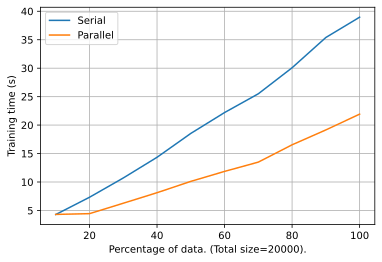

In [26]:
plt.figure(figsize=(6, 4))
plt.plot(range(10, 100+10, 10), serial_times, label="Serial")
plt.plot(range(10, 100+10, 10), parallel_times, label="Parallel")

plt.xlabel(f"Percentage of data. (Total size={len(X_train)}).")
plt.ylabel(f"Training time (s)")
plt.legend()
plt.grid()

Notice that training times are linear in the dataset size. Training time with parallel processing has a smaller slope, which makes sense since there are more workers which introduces a constant reduction factor for the training time. I was expecting to see some overhead with parallel (initializing / closing workers and consolidating results from different workers). But from the graph, there seems to be little to none! (Joblib good.)

### Testing consistency of parallel and serial predictions

Testing if predictions agree between serial and parallel training:

In [27]:
# These models are already trained as a side-effect of timing
yp_test = parallel.predict_proba(X_test)[:, 1]
ys_test = serial.predict_proba(X_test)[:, 1]
assert (yp_test - ys_test).mean() < 1e-16

In [28]:
parallel.metafeatures_.head()

,lr_0,lr_cnt_0,lr_1,linreg_1,xgb_1,linreg_2,xgb_2,blender_3
0,0.052181,0.001930,0.000659,-0.375688,0.000111,-0.375688,0.000111,955.843253
1,0.029885,0.000006,0.000640,-0.375688,0.000111,-0.375688,0.000111,1038.124480
2,0.052702,0.000440,0.000658,-0.375688,0.000111,-0.375688,0.000111,955.843253
3,0.917899,0.996462,0.999197,-0.125688,0.999888,-0.125688,0.999888,1841.468940
4,0.982799,0.999165,0.999260,-0.125688,0.999888,-0.125688,0.999888,1704.229475


In [29]:
serial.metafeatures_.head()

,lr_0,lr_cnt_0,lr_1,linreg_1,xgb_1,linreg_2,xgb_2,blender_3
0,0.052181,0.001930,0.000659,-0.375688,0.000111,-0.375688,0.000111,955.843253
1,0.029885,0.000006,0.000640,-0.375688,0.000111,-0.375688,0.000111,1038.124480
2,0.052702,0.000440,0.000658,-0.375688,0.000111,-0.375688,0.000111,955.843253
3,0.917899,0.996462,0.999197,-0.125688,0.999888,-0.125688,0.999888,1841.468940
4,0.982799,0.999165,0.999260,-0.125688,0.999888,-0.125688,0.999888,1704.229475


## Conclusion

In this notebook we have implemented a class for model stacking and blending on a text classification task. We saw that stacking uncorrelated models result in some improvement in performance by creating metafeatures which are prediction probabilities of lower level models. 

The main tools constructed in this notebook are the **`StackingClassifierParallel`** and the **`Blender`** classes. These classes expose a `.fit()` and `.predict_proba()` method similar to scikit-learn models, as well as learned attributes `.metafeatures_` and `.coef_` which can be useful for hacking into the models. The parallel implementation resulted in significant reduction in training time, without any undesirable side-effects. The implementation of blending uses the Nelder-Mead method from `scipy.optimize` to find the best blending coefficents for the columns.

### Parallelized model training
Parallelism can perhaps be implemented during inference, but this would depend on the exact use case. 
We got into some trouble with getting reproducible results using `joblib.Parallel`. This is solved by cloning the models in the right places. Also, we had issues making parallel work with XGBoost. But the current configuration seems to work in a Kaggle Kernel.

### Further improvements
To further support hacking into the models and metafeatures of the stacker, we can implement a `start_from_level` parameter on the fit function which assumes metafeatures from levels `0, 1, ..., start_from_level-1` has been appended to the `.metafeatures_` attribute, and that the corresponding models have been trained on the respective whole columns, ready for inference. Some rules are needed to make this work, for one, the models dict should include the models to be injected. And that there must be a function to supply the metafeatures so that naming conventions are adhered to &mdash; both are easy. This is nice if we have large models to stack and we don't have the resources to retrain them.